In [1]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\kamal\Downloads\walmart Retail Dataset.xlsx"
df = pd.ExcelFile(file_path).parse('walmart Retail Data')

# Check missing values
print(df[['Customer Age', 'Product Base Margin']].isna().sum())

# Handle missing values
df['Customer Age'] = df['Customer Age'].fillna(df['Customer Age'].median())
df['Product Base Margin'] = df['Product Base Margin'].fillna(df['Product Base Margin'].mean())

# Confirm missing values are handled
print(df[['Customer Age', 'Product Base Margin']].isna().sum())


Customer Age           903
Product Base Margin     63
dtype: int64
Customer Age           0
Product Base Margin    0
dtype: int64


C:\Users\kamal\AppData\Local\Temp\ipykernel_2240\3353368783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Order Month'] = df_filtered['Order Date'].dt.to_period('M')


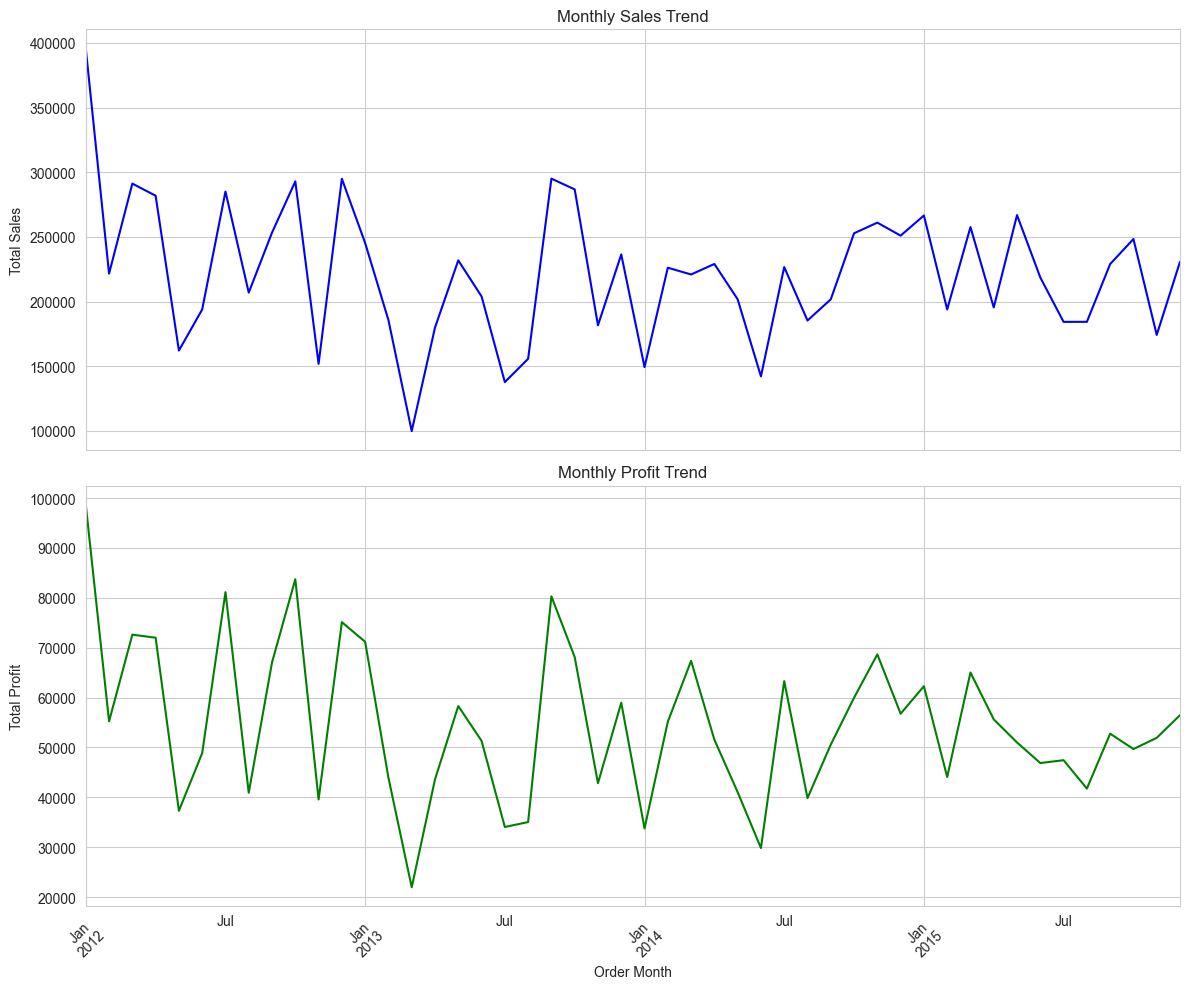

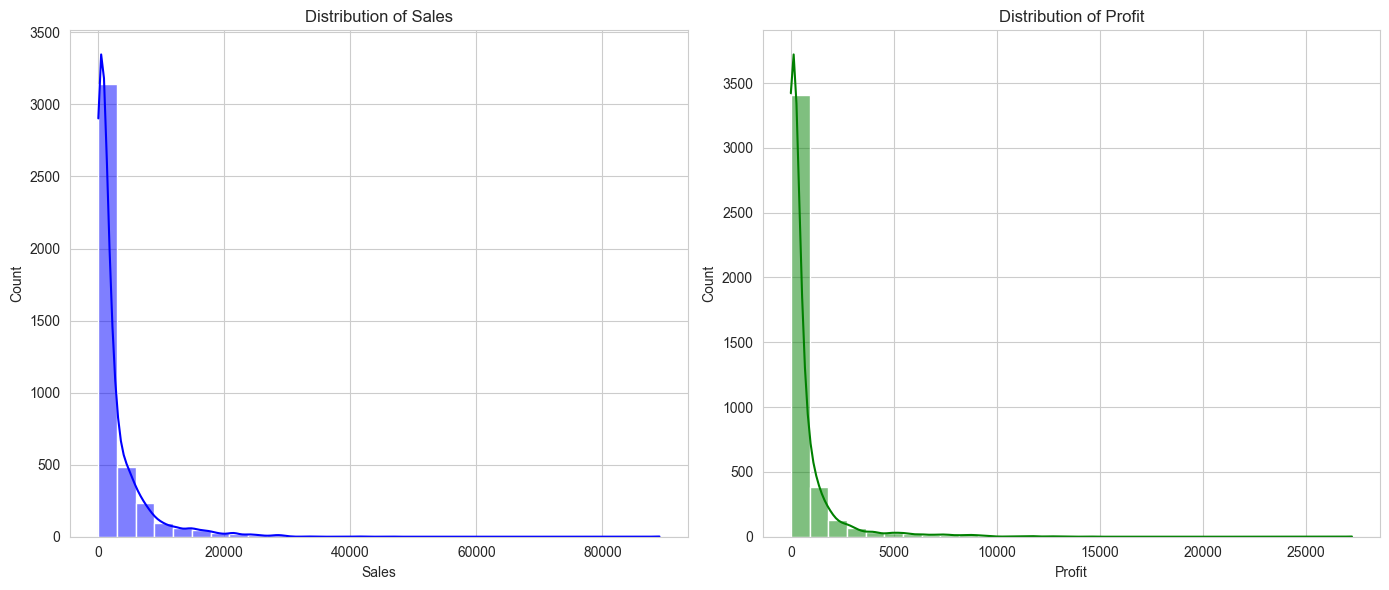

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out negative profit values
df_filtered = df[df['Profit'] >= 0]

# Extract the year and month for time-series analysis
df_filtered['Order Month'] = df_filtered['Order Date'].dt.to_period('M')

# Aggregate sales and profit by month
monthly_metrics = df_filtered.groupby('Order Month')[['Sales', 'Profit']].sum()

# Plot trends over time
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Sales trend
monthly_metrics['Sales'].plot(ax=axes[0], color='blue', title='Monthly Sales Trend')
axes[0].set_ylabel('Total Sales')

# Profit trend
monthly_metrics['Profit'].plot(ax=axes[1], color='green', title='Monthly Profit Trend')
axes[1].set_ylabel('Total Profit')

plt.xlabel('Order Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize distribution (filtered)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df_filtered['Sales'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Sales')

sns.histplot(df_filtered['Profit'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Profit')

plt.tight_layout()
plt.show()


ADF Statistic: -7.051210351232603
p-value: 5.520440777337416e-10
Data is stationary


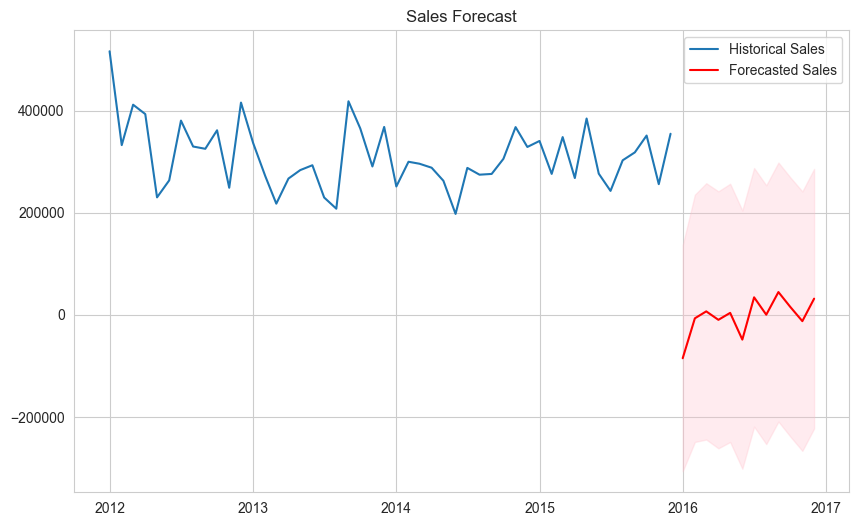

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Ensure the data is stationary
def test_stationarity(timeseries):
    adf_test = adfuller(timeseries)
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    if adf_test[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

# Test for stationarity
sales_data = monthly_metrics['Sales']

# Convert PeriodIndex to DatetimeIndex if necessary
if isinstance(sales_data.index, pd.PeriodIndex):
    sales_data.index = sales_data.index.to_timestamp()

test_stationarity(sales_data)

# Difference the data if non-stationary
sales_diff = sales_data.diff().dropna()

# Fit SARIMA model
model = SARIMAX(sales_diff, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Forecast future values
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Convert forecast index to datetime if necessary
if isinstance(forecast.predicted_mean.index, pd.PeriodIndex):
    forecast.predicted_mean.index = forecast.predicted_mean.index.to_timestamp()
if isinstance(forecast_ci.index, pd.PeriodIndex):
    forecast_ci.index = forecast_ci.index.to_timestamp()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(sales_data, label='Historical Sales')
plt.plot(forecast.predicted_mean, label='Forecasted Sales', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Sales Forecast')
plt.legend()
plt.show()
